In [3]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt 
from ase import Atoms
from ase.build import graphene
from ase.visualize import view
from ase.build import graphene_nanoribbon
from ase.neighborlist import neighbor_list
from ase.build import make_supercell

import abtem

# Structure


Cell([35.36, 59.02829152194734, 50.0])


(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='x [Å]'>)

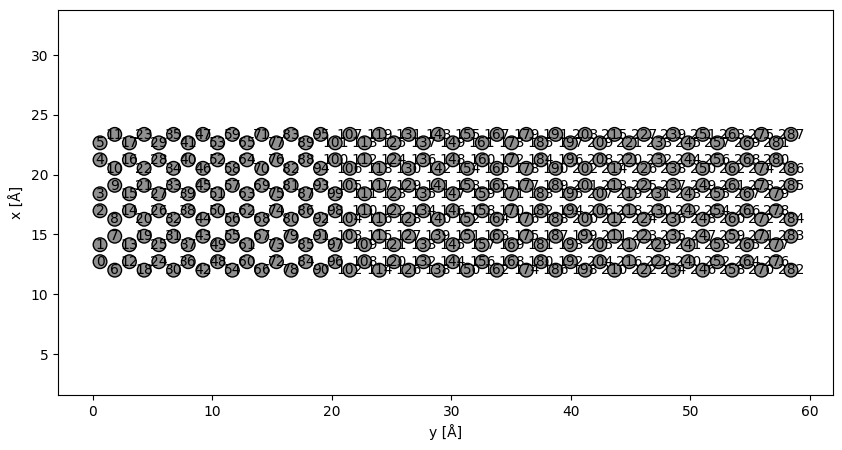

In [65]:
from functions import zgnr

Vpp_pi0=-2.7
Vpp_sigma0=0.48

N = 6 # width
L = 1 # length

num_cells = 24

# N = 2 # width
# L = 1 # length

NR = zgnr(N,L)

NR.rotate(90, (1, 0, 0), rotate_cell=False)

NR.cell[1] = [0, NR.cell[2,2],0]
NR.cell[2] = [0,0,50.0]


# center in the cell
NR.center()

# sort atoms by x, then y (correct order)
xyz = NR.get_positions()
sorted_indices = np.lexsort((xyz[:, 0], xyz[:, 1]))  # no z sorting

NR = NR[sorted_indices]

# repeat
NR = NR.repeat((1,num_cells,1))
# atoms = atoms.repeat((1,5,1))


print(NR.cell)
#view(NR)
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))

# Top flake

In [119]:
top.symbols = 'N'
top

Atoms(symbols='N144', pbc=[False, False, True], cell=[35.36, 59.02829152194734, 50.0])

In [113]:
atoms

Atoms(symbols='C432', pbc=[False, False, True], cell=[35.36, 59.02829152194734, 50.0])

(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

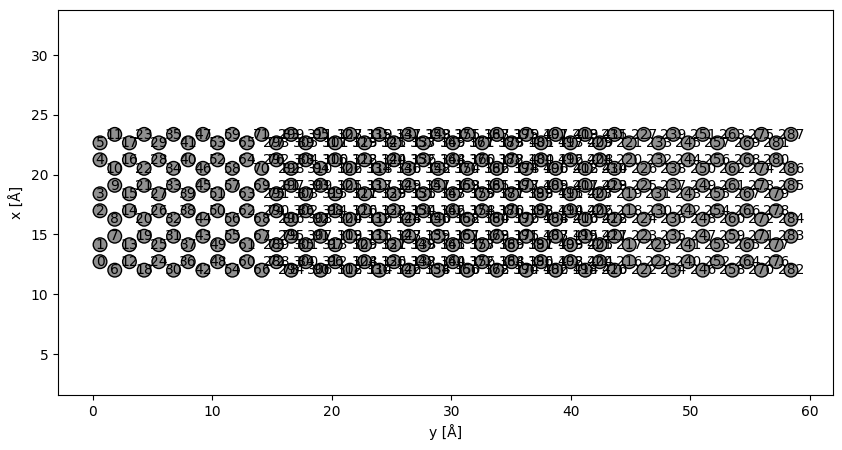

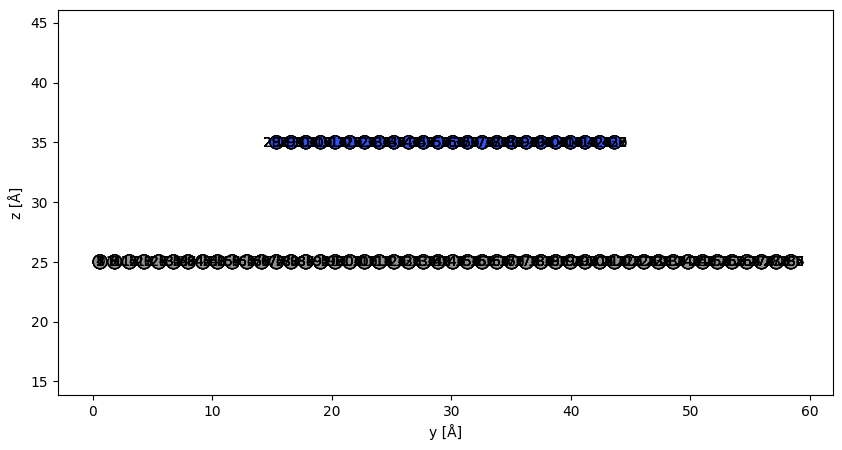

In [120]:
bottom = NR.copy()
top = NR.copy()

top.positions[:,2] += 10.0
num_del = 36*2

del top[0:num_del]
del top[len(top)-num_del::]

top.symbols = 'N'
atoms = bottom + top

abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))
abtem.show_atoms(atoms,plane='yz',numbering=True,merge = False,show_cell=False,figsize=(10,5))


# Hamilton

In [109]:
#atoms = NR.copy()

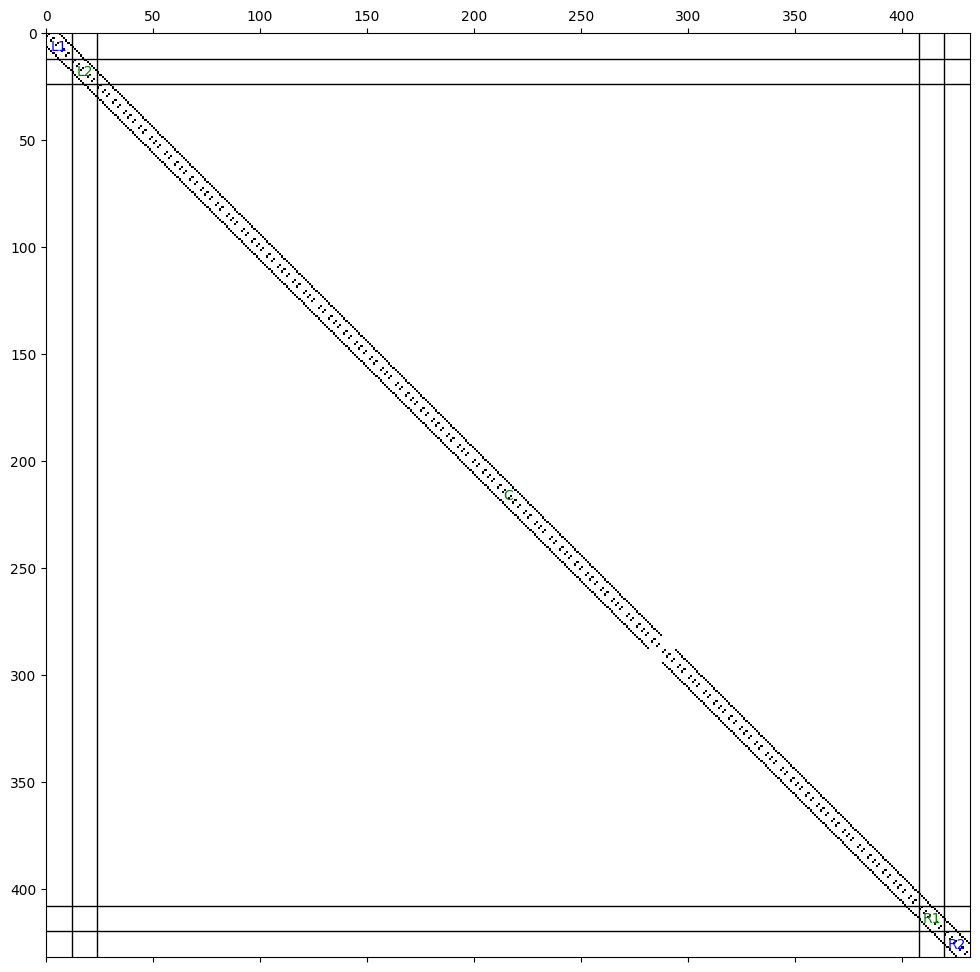

In [111]:
from functions import slater_koster
H,H_TB,H_SK,_,_= slater_koster(atoms)


nL = 12
nR = 12

Hbig = H
nC = Hbig.shape[0] - 2*nL - 2*nR

# Boundaries
b0 = 0
b1 = nL
b2 = 2*nL
b3 = 2*nL + nC
b4 = 2*nL + nC + nR
b5 = Hbig.shape[0]

plt.figure(figsize=(12,12))
plt.spy(Hbig,extent=(0, Hbig.shape[0], Hbig.shape[0],0))
# Draw block boundaries
for b in [b1, b2, b3, b4]:
    plt.axhline(b, color='k', linewidth=1)
    plt.axvline(b, color='k', linewidth=1)

# Add text labels
plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='blue')

plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='green')
plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='green')
plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='green')
plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='blue')

plt.show()

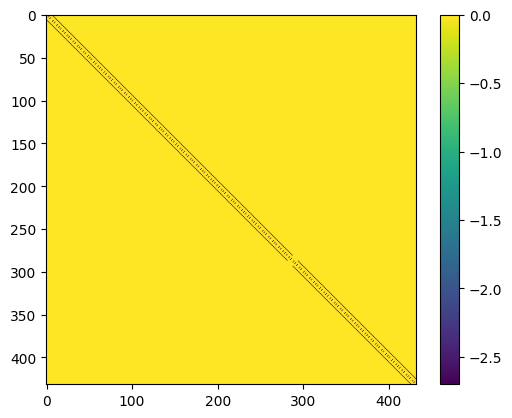

In [116]:
plt.imshow(Hbig)
plt.colorbar()

In [85]:
from functions import SplitHam
HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD =SplitHam(H, nL, nR)

# LDOS

In [86]:
from functions import compute_transmission_caroli

# Calculate spectrum
energies = np.linspace(-10.0, 10.0, 1000)
results_2 = [compute_transmission_caroli(E, 1e-5,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=2) for E in energies]

# Unpack each column of the results
transmission_2, gl_s_2, gl_b_2, gr_s_2, gr_b_2, g_d_2,sigma_l_2,sigma_r_2 = map(np.array, zip(*results_2))

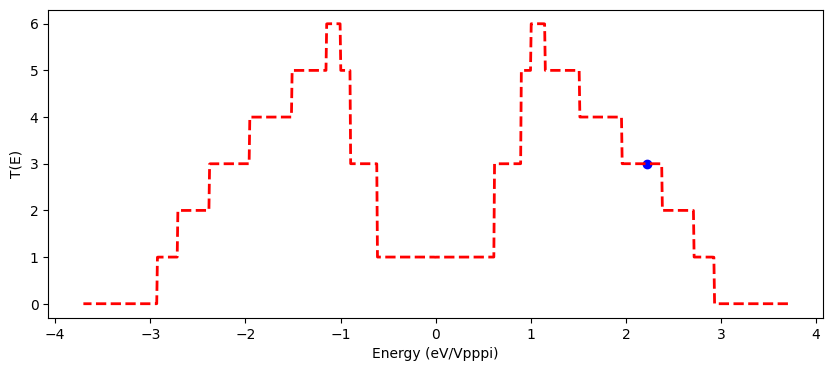

In [106]:
energy_idx = 200 

# --- Plotting ---
plt.figure(figsize=(10, 4))
plt.plot(energies/(-2.7), transmission_2, '--r', lw=2)
plt.scatter(energies[energy_idx]/(-2.7),transmission_2[energy_idx],color = 'b')
plt.xlabel("Energy (eV/Vpppi)")
plt.ylabel("T(E)")
plt.show()

<Figure size 2000x800 with 0 Axes>

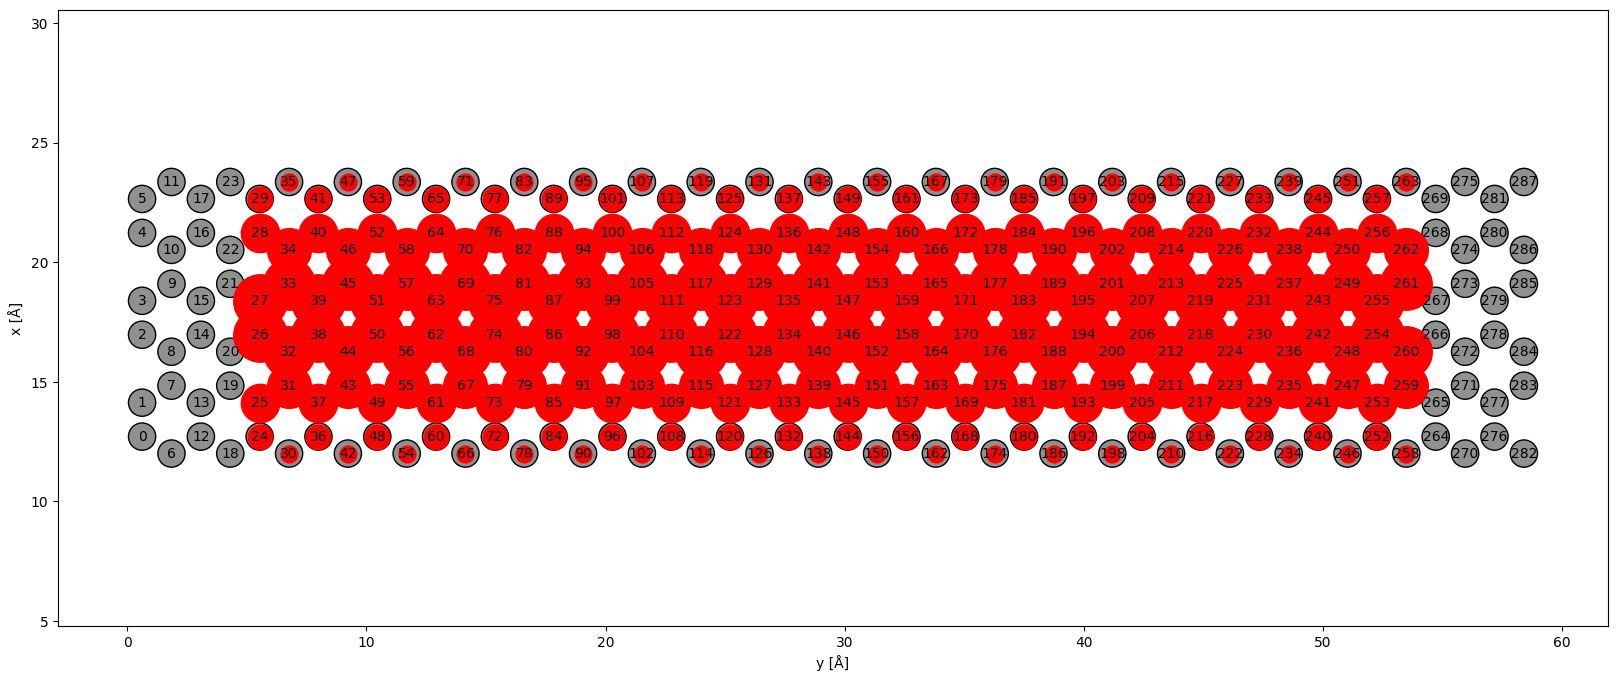

In [105]:

plt.figure(figsize=(20, 8))
abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8))
for i,idx in enumerate(range(nL*2,nL+nC+nR)): 
    plt.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[105]))[i],c='r')
